In [ ]:
!pip install tensorflow opencv-python scikit-learn numpy matplotlib


In [ ]:
import os
import json

# Ensure Kaggle API client is installed
!pip install -q kaggle

# Set up Kaggle API credentials
if not os.path.exists('/root/.kaggle'):
    os.makedirs('/root/.kaggle')
!cp kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

# Download the CEDAR dataset
!kaggle datasets download -d shreelakshmigp/cedardataset

# Unzip the dataset
!unzip cedardataset.zip


cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/shreelakshmigp/cedardataset
License(s): unknown
cedardataset.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  cedardataset.zip
replace signatures/Readme.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
!ls
!ls signatures


cedardataset.zip  sample_data  signatures
full_forg  full_org  Readme.txt


In [ ]:
!ls signatures/full_org | head -n 5 # List first 5 files in full_org
!ls signatures/full_forg | head -n 5 # List first 5 files in full_forg


original_10_10.png
original_10_11.png
original_10_12.png
original_10_13.png
original_10_14.png
forgeries_10_10.png
forgeries_10_11.png
forgeries_10_12.png
forgeries_10_13.png
forgeries_10_14.png


In [ ]:
import numpy as np
import os
import cv2


def load_signatures(data_dir, limit=2000): # Added 'limit' parameter
    genuine_signatures = []
    forged_signatures = []
    genuine_writers = []
    forged_writers = []
    genuine_count = 0 # Counters to limit loading
    forged_count = 0

    print("--- load_signatures function started ---") # ADDED: Print at the start of the function

    genuine_dir = os.path.join(data_dir, 'full_org')
    forged_dir = os.path.join(data_dir, 'full_forg')

    print(f"Genuine signatures directory: {genuine_dir}") # ADDED: Print directory paths
    print(f"Forged signatures directory: {forged_dir}") # ADDED: Print directory paths

    # Load Genuine Signatures (Limited)
    try:
        for filename in os.listdir(genuine_dir):
            if genuine_count >= limit: # Stop loading when limit is reached
                break
            if filename.startswith('original_') and filename.endswith('.png'):
                img_path = os.path.join(genuine_dir, filename)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    genuine_signatures.append(img)
                    writer_id = filename[len('original_'):filename.find('_', len('original_'))]
                    writer_id_str = str(writer_id)
                    genuine_writers.append(writer_id_str)
                    genuine_count += 1 # Increment counter
                    print(f"  Loaded genuine: {filename}, Writer ID: {writer_id_str}, Shape: {img.shape}") # ADDED: Print for each loaded image
                else:
                    print(f"Error loading image: {img_path}")
            else:
                print(f"Skipping file (genuine): {filename}") # ADDED: Print skipped files
    except Exception as e:
        print(f"Error loading genuine signatures: {e}") # ADDED: Error handling for genuine loading

    # Load Forged Signatures (Limited)
    try:
        for filename in os.listdir(forged_dir):
            if forged_count >= limit: # Stop loading when limit is reached
                break
            if filename.startswith('forgeries_') and filename.endswith('.png'):
                img_path = os.path.join(forged_dir, filename)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    forged_signatures.append(img)
                    writer_id = filename[len('forgeries_'):filename.find('_', len('forgeries_'))]
                    writer_id_str = str(writer_id)
                    forged_writers.append(writer_id_str)
                    forged_count += 1 # Increment counter
                    print(f"  Loaded forged: {filename}, Writer ID: {writer_id_str}, Shape: {img.shape}") # ADDED: Print for each loaded image
                else:
                    print(f"Error loading image: {img_path}")
            else:
                print(f"Skipping file (forged): {filename}") # ADDED: Print skipped files
    except Exception as e:
        print(f"Error loading forged signatures: {e}") # ADDED: Error handling for forged loading


    print("--- Dataset Size Summary (Limited) ---") # Modified Summary Output
    print(f"Number of genuine signatures loaded (limited to {limit}):", len(genuine_signatures))
    print(f"Number of forged signatures loaded (limited to {limit}):", len(forged_signatures))
    print(f"Number of genuine writer IDs loaded (limited to {limit}):", len(genuine_writers))
    print(f"Number of forged writer IDs loaded (limited to {limit}):", len(forged_writers))
    print("--- load_signatures function finished ---") # ADDED: Print at the end of the function

    return genuine_signatures, forged_signatures, genuine_writers, forged_writers


In [ ]:
from sklearn.model_selection import train_test_split

def split_data_writer_independent(genuine_signatures, forged_signatures, genuine_writers, forged_writers, test_size=0.2, validation_size=0.15, random_state=42):
    """Splits data into training, validation, and test sets, ensuring writer independence, and returns writer IDs for each set."""

    unique_writers = sorted(list(set(genuine_writers)))
    train_writers, test_val_writers = train_test_split(unique_writers, test_size=test_size + validation_size, random_state=random_state)
    val_writers, test_writers = train_test_split(test_val_writers, test_size=test_size / (test_size + validation_size) if (test_size + validation_size) > 0 else 0, random_state=random_state)

    train_genuine_sigs, val_genuine_sigs, test_genuine_sigs = [], [], []
    train_forged_sigs, val_forged_sigs, test_forged_sigs = [], [], []
    train_genuine_writer_ids, val_genuine_writer_ids, test_genuine_writer_ids = [], [], [] # Lists for writer IDs
    train_forged_writer_ids, val_forged_writer_ids, test_forged_writer_ids = [], [], []   # Lists for writer IDs


    # Assign genuine signatures and writer IDs to sets based on writer ID
    for sig, writer_id in zip(genuine_signatures, genuine_writers):
        if writer_id in train_writers:
            train_genuine_sigs.append(sig)
            train_genuine_writer_ids.append(writer_id) # Add writer ID to train list
        elif writer_id in val_writers:
            val_genuine_sigs.append(sig)
            val_genuine_writer_ids.append(writer_id)   # Add writer ID to val list
        elif writer_id in test_writers:
            test_genuine_sigs.append(sig)
            test_genuine_writer_ids.append(writer_id)  # Add writer ID to test list

    # Assign forged signatures and writer IDs to sets based on writer ID
    for sig, writer_id in zip(forged_signatures, forged_writers):
        if writer_id in train_writers:
            train_forged_sigs.append(sig)
            train_forged_writer_ids.append(writer_id)   # Add writer ID to train list
        elif writer_id in val_writers:
            val_forged_sigs.append(sig)
            val_forged_writer_ids.append(writer_id)     # Add writer ID to val list
        elif writer_id in test_writers:
            test_forged_sigs.append(sig)
            test_forged_writer_ids.append(writer_id)    # Add writer ID to test list

    return (train_genuine_sigs, train_forged_sigs, val_genuine_sigs, val_forged_sigs, test_genuine_sigs, test_forged_sigs,
            train_genuine_writer_ids, train_forged_writer_ids, val_genuine_writer_ids, val_forged_writer_ids, test_genuine_writer_ids, test_forged_writer_ids) # Return writer ID lists as well


In [ ]:
import cv2
import numpy as np
print("hello")
def preprocess_signatures(signatures, target_size=(64, 64), binarize=True): # Corrected target_size to (64, 64)
    processed_signatures = []
    for img in signatures:
        print(f"Shape of image BEFORE resizing: {img.shape}") # Correctly placed print statement
        resized_img = cv2.resize(img, target_size) # Resize

        if binarize: # Apply binarization if binarize flag is True
            _, binarized_img = cv2.threshold(resized_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU) # Use Otsu's thresholding for automatic threshold selection
            normalized_img = binarized_img / 255.0 # Normalize binarized image to 0-1
        else:
            normalized_img = resized_img / 255.0      # Normalize grayscale image if binarization is False

        processed_signatures.append(normalized_img)
    return np.array(processed_signatures)


hello


In [ ]:
import numpy as np
import random

def create_signature_pairs(genuine_signatures, forged_signatures, genuine_writers, forged_writers):
    """
    Generates pairs of signatures for Siamese network training and their labels.
    [... function documentation as before ...]
    """
    pairs = []
    labels = []

    num_genuine = len(genuine_signatures)
    num_forged = len(forged_signatures)

    print("Starting create_signature_pairs...") # ADDED
    print(f"Number of genuine signatures received: {num_genuine}") # ADDED
    print(f"Number of forged signatures received: {num_forged}") # ADDED

    # 1. Genuine Pairs - Signatures from the same writer
    writer_signature_map_genuine = {} # Group genuine signatures by writer
    for sig, writer_id in zip(genuine_signatures, genuine_writers):
        print(f"  Genuine - Writer ID: {writer_id}, Type: {type(writer_id)}") # ADDED
        if writer_id not in writer_signature_map_genuine:
            writer_signature_map_genuine[writer_id] = []
        writer_signature_map_genuine[writer_id].append(sig)

    print(f"Genuine writer map keys: {writer_signature_map_genuine.keys()}") # ADDED

    for writer_id in writer_signature_map_genuine:
        signatures_of_writer = writer_signature_map_genuine[writer_id]
        if len(signatures_of_writer) < 2: # Need at least 2 genuine signatures to form a genuine pair
            continue
        for i in range(len(signatures_of_writer)):
            for j in range(i + 1, len(signatures_of_writer)): # Avoid duplicate pairs and pairing with itself
                pairs.append([signatures_of_writer[i], signatures_of_writer[j]]) # Form genuine pair
                labels.append(1) # Label as genuine (1)


    # 2. Forged Pairs - Signatures from different writers (or genuine vs. forgery - in this dataset, forgeries are linked to writers)
    writer_signature_map_forged = {} # Group forged signatures by writer (though forgeries are not strictly writer-specific in CEDAR, using writer ID prefix)
    for sig, writer_id in zip(forged_signatures, forged_writers):
        print(f"  Forged - Writer ID: {writer_id}, Type: {type(writer_id)}") # ADDED
        if writer_id not in writer_signature_map_forged:
            writer_signature_map_forged[writer_id] = []
        writer_signature_map_forged[writer_id].append(sig)

    print(f"Forged writer map keys: {writer_signature_map_forged.keys()}") # ADDED


    for writer_id in writer_signature_map_genuine: # Iterate through genuine writers
        if writer_id not in writer_signature_map_forged: # Skip if no forgeries for this writer (shouldn't happen in CEDAR)
            continue

        genuine_writer_signatures = writer_signature_map_genuine[writer_id]
        forged_writer_signatures = writer_signature_map_forged[writer_id]

        for genuine_sig in genuine_writer_signatures:
            # Pair genuine signature with a forged signature from the same writer (skilled forgery case)
            if forged_writer_signatures: # Ensure there are forgeries for this writer
                forged_sig = random.choice(forged_writer_signatures) # Randomly pick a forgery from the same writer
                pairs.append([genuine_sig, forged_sig])
                labels.append(0) # Label as forged (0)


    print(f"Number of pairs created: {len(pairs)}") # ADDED
    print("Ending create_signature_pairs...") # ADDED
    return np.array(pairs), np.array(labels) # Return pairs and labels as NumPy arrays


In [ ]:
print("split_data_writer_independent function call completed (supposedly)")


split_data_writer_independent function call completed (supposedly)


In [ ]:
data_dir = 'signatures'
genuine_sigs, forged_sigs, genuine_writers, forged_writers = load_signatures(data_dir)

processed_genuine_sigs = preprocess_signatures(genuine_sigs)
processed_forged_sigs = preprocess_signatures(forged_sigs)

(train_genuine_sigs, train_forged_sigs,
 val_genuine_sigs, val_forged_sigs,
 test_genuine_sigs, test_forged_sigs,
 train_genuine_writer_ids, train_forged_writer_ids,
 val_genuine_writer_ids, val_forged_writer_ids,
 test_genuine_writer_ids, test_forged_writer_ids) = split_data_writer_independent( # Capture all 12 returned lists
    processed_genuine_sigs, processed_forged_sigs, genuine_writers, forged_writers,
    test_size=0.2, validation_size=0.15, random_state=42
)


# Create training pairs - NOW USING CORRECT WRITER ID LISTS
# Create training pairs - NOW USING CORRECT WRITER ID LISTS
train_pairs, train_labels = create_signature_pairs(
    train_genuine_sigs, train_forged_sigs, train_genuine_writer_ids, train_forged_writer_ids
)

# Create validation pairs - NOW USING CORRECT WRITER ID LISTS
val_pairs, val_labels = create_signature_pairs(
    val_genuine_sigs, val_forged_sigs, val_genuine_writer_ids, val_forged_writer_ids
)


print("Number of Training Pairs:", len(train_pairs))
print("Number of Validation Pairs:", len(val_pairs))
print("Shape of a Training Pair (first image):", train_pairs[0][0].shape)
print("Shape of Training Labels:", train_labels.shape)


Streaming output truncated to the last 5000 lines.
  Loaded forged: forgeries_51_10.png, Writer ID: 51, Shape: (342, 594)
  Loaded forged: forgeries_42_6.png, Writer ID: 42, Shape: (366, 642)
  Loaded forged: forgeries_36_21.png, Writer ID: 36, Shape: (276, 360)
  Loaded forged: forgeries_1_23.png, Writer ID: 1, Shape: (312, 576)
  Loaded forged: forgeries_47_24.png, Writer ID: 47, Shape: (504, 642)
  Loaded forged: forgeries_18_3.png, Writer ID: 18, Shape: (210, 654)
  Loaded forged: forgeries_26_16.png, Writer ID: 26, Shape: (384, 624)
  Loaded forged: forgeries_25_18.png, Writer ID: 25, Shape: (306, 342)
  Loaded forged: forgeries_7_6.png, Writer ID: 7, Shape: (672, 756)
  Loaded forged: forgeries_8_1.png, Writer ID: 8, Shape: (528, 630)
  Loaded forged: forgeries_40_19.png, Writer ID: 40, Shape: (312, 558)
  Loaded forged: forgeries_45_12.png, Writer ID: 45, Shape: (456, 576)
  Loaded forged: forgeries_32_10.png, Writer ID: 32, Shape: (252, 642)
  Loaded forged: forgeries_33_1.png,

In [ ]:
import numpy as np

# 1. Reshape Training Pairs
input_shape = (64, 64, 1) # Make sure this matches your target_size and input_shape

# Initialize empty arrays to store the two branches of the input pairs
pairs_train_img1 = np.zeros((len(train_pairs), input_shape[0], input_shape[1], input_shape[2]))
pairs_train_img2 = np.zeros((len(train_pairs), input_shape[0], input_shape[1], input_shape[2]))

for i in range(len(train_pairs)):
    pairs_train_img1[i,:,:,:] = train_pairs[i][0].reshape(input_shape) # Reshape and assign the first image of the pair
    pairs_train_img2[i,:,:,:] = train_pairs[i][1].reshape(input_shape) # Reshape and assign the second image of the pair

# Convert to NumPy arrays and ensure float32 data type for images, int32 for labels
train_labels = np.array(train_labels).astype('int32') # Or 'float32' if you used categorical crossentropy and one-hot encoded labels

# 2. Reshape Validation Pairs (Do the same for validation data)
pairs_val_img1 = np.zeros((len(val_pairs), input_shape[0], input_shape[1], input_shape[2]))
pairs_val_img2 = np.zeros((len(val_pairs), input_shape[0], input_shape[1], input_shape[2]))

for i in range(len(val_pairs)):
    pairs_val_img1[i,:,:,:] = val_pairs[i][0].reshape(input_shape) # Reshape and assign the first image of the pair
    pairs_val_img2[i,:,:,:] = val_pairs[i][1].reshape(input_shape) # Reshape and assign the second image of the pair

val_labels = np.array(val_labels).astype('int32') # Or 'float32'


# --- Print Shapes to Verify ---
print("--- Reshaped Data Summary ---")
print("Shape of pairs_train_img1:", pairs_train_img1.shape)
print("Shape of pairs_train_img2:", pairs_train_img2.shape)
print("Shape of train_labels:", train_labels.shape)

print("Shape of pairs_val_img1:", pairs_val_img1.shape)
print("Shape of pairs_val_img2:", pairs_val_img2.shape)
print("Shape of val_labels:", val_labels.shape)

print("\nData type of pairs_train_img1:", pairs_train_img1.dtype)
print("Data type of train_labels:", train_labels.dtype)


--- Reshaped Data Summary ---
Shape of pairs_train_img1: (10500, 64, 64, 1)
Shape of pairs_train_img2: (10500, 64, 64, 1)
Shape of train_labels: (10500,)
Shape of pairs_val_img1: (2400, 64, 64, 1)
Shape of pairs_val_img2: (2400, 64, 64, 1)
Shape of val_labels: (2400,)

Data type of pairs_train_img1: float64
Data type of train_labels: int32


In [ ]:
print("--- Data Split Summary ---")
print("Number of training genuine signatures:", len(train_genuine_sigs))
print("Number of training forged signatures:", len(train_forged_sigs))
print("Number of validation genuine signatures:", len(val_genuine_sigs))
print("Number of validation forged signatures:", len(val_forged_sigs))
print("Number of test genuine signatures:", len(test_genuine_sigs))
print("Number of test forged signatures:", len(test_forged_sigs))

print("\n--- Training Writer IDs (First 10) ---")
print("Genuine Writers:", train_genuine_writer_ids[:10])
print("Forged Writers:", train_forged_writer_ids[:10])

print("\n--- Validation Writer IDs (First 10) ---")
print("Genuine Writers:", val_genuine_writer_ids[:10])
print("Forged Writers:", val_forged_writer_ids[:10])

print("\n--- Test Writer IDs (First 10) ---")
print("Genuine Writers:", test_genuine_writer_ids[:10])
print("Forged Writers:", test_forged_writer_ids[:10])

print("\n--- Unique Writers in Splits ---")
print("Unique training writers (genuine):", sorted(list(set(train_genuine_writer_ids))))
print("Unique validation writers (genuine):", sorted(list(set(val_genuine_writer_ids))))
print("Unique test writers (genuine):", sorted(list(set(test_genuine_writer_ids))))


--- Data Split Summary ---
Number of training genuine signatures: 840
Number of training forged signatures: 840
Number of validation genuine signatures: 192
Number of validation forged signatures: 192
Number of test genuine signatures: 288
Number of test forged signatures: 288

--- Training Writer IDs (First 10) ---
Genuine Writers: ['48', '29', '24', '11', '9', '9', '3', '48', '11', '28']
Forged Writers: ['53', '36', '19', '9', '5', '30', '22', '10', '5', '16']

--- Validation Writer IDs (First 10) ---
Genuine Writers: ['20', '20', '47', '20', '7', '4', '27', '7', '20', '47']
Forged Writers: ['33', '4', '4', '7', '7', '17', '27', '27', '47', '47']

--- Test Writer IDs (First 10) ---
Genuine Writers: ['54', '21', '12', '40', '25', '38', '25', '39', '14', '39']
Forged Writers: ['39', '52', '52', '13', '15', '25', '38', '39', '39', '49']

--- Unique Writers in Splits ---
Unique training writers (genuine): ['1', '10', '11', '16', '18', '19', '2', '22', '23', '24', '26', '28', '29', '3', '

In [ ]:
from tensorflow.keras import layers, models

def create_base_network(input_shape):
    """
    Simplified base CNN architecture to extract signature embeddings.
    Reduced filters to decrease memory usage.
    """
    input_signature = layers.Input(shape=input_shape)

    # Convolutional blocks - Reduced filters
    x = layers.Conv2D(16, (3, 3), activation='relu')(input_signature) # Reduced to 16 filters
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(32, (3, 3), activation='relu')(x) # Reduced to 32 filters
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Flatten()(x) # Flatten to dense layer

    # Dense layers for embedding - Kept embedding size, but you can reduce if needed
    x = layers.Dense(128, activation='relu')(x) # Embedding layer
    x = layers.Dropout(0.1)(x) # Dropout for regularization
    x = layers.Dense(64, activation='relu')(x) # Further embedding layer

    return models.Model(inputs=input_signature, outputs=x)


In [ ]:
from tensorflow.keras.losses import Loss
import tensorflow.keras.backend as K

class ContrastiveLoss(Loss):
    def __init__(self, margin=1.0):
        super().__init__()
        self.margin = margin

    def call(self, y_true, y_pred):
        square_pred = K.square(y_pred)
        margin_square = K.square(K.maximum(self.margin - y_pred, 0))
        return K.mean(y_true * square_pred + (1 - y_true) * margin_square)


In [ ]:
from tensorflow.keras import layers, models, Input
import tensorflow.keras.backend as K

def create_siamese_network(input_shape, base_network_model): # Corrected function definition
    """
    Constructs a Siamese Network using the given base network and L1 distance.
    """
    # Input layers for signature pairs
    input_sig_1 = Input(shape=input_shape, name="signature_input_1")
    input_sig_2 = Input(shape=input_shape, name="signature_input_2")

    # Create twin networks using the base network (sharing weights)
    embedding_network = base_network_model # Use the *model instance* passed as argument
    embedding_1 = embedding_network(input_sig_1) # Process input 1
    embedding_2 = embedding_network(input_sig_2) # Process input 2

    # L1 distance layer to compare embeddings (Corrected to L1 Distance)
    L1_distance = layers.Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))([embedding_1, embedding_2]) # Compute L1 distance

    # Output is the L1 distance
    output = layers.Dense(1, activation='sigmoid')(L1_distance) # Add a dense layer with sigmoid for classification

    return models.Model(inputs=[input_sig_1, input_sig_2], outputs=output) # Output is now 'output'


In [ ]:
import tensorflow as tf # Make sure you have this import

# Define input shape (consistent with preprocessing)
input_shape = (64, 64, 1) # Use the smaller target_size (64x64)

# Create base network
base_cnn = create_base_network(input_shape)

# Create Siamese network - using L1 distance version
siamese_net = create_siamese_network(input_shape, base_cnn) # Pass base_cnn instance

# Instantiate contrastive loss (if you were intending to use it - for L1 with sigmoid, BinaryCrossentropy is more typical)
# contrastive_loss_func = ContrastiveLoss(margin=1.0) # If you still want to use Contrastive Loss

# Use Binary Crossentropy loss - more suitable for sigmoid output and classification
binary_crossentropy_loss = tf.keras.losses.BinaryCrossentropy()

# Optimizer
optimizer = tf.keras.optimizers.Adam(0.0001)

# Compile the Siamese network - using binary crossentropy loss
siamese_net.compile(loss=binary_crossentropy_loss, optimizer=optimizer, metrics=['accuracy']) # Compile with binary crossentropy and accuracy

# Model Summary
siamese_net.summary()


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ signature_input_1         │ (None, 64, 64, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ signature_input_2         │ (None, 64, 64, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional_10             │ (None, 64)             │        816,000 │ signature_input_1[0][… │
│ (Functional)              │                        │                │ signature_input_2[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_5 (Lambda)         │ (None, 64)             │              0 │ functional_10[0][0],   │
│                           │                        │                │ functional_10[1][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_15 (Dense)          │ (None, 1)              │             65 │ lambda_5[0][0]         │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 816,065 (3.11 MB)

 Trainable params: 816,065 (3.11 MB)

 Non-trainable params: 0 (0.00 B)

Starting training...
Epoch 1/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.9096 - loss: 0.3595 - val_accuracy: 0.9200 - val_loss: 0.6163
Epoch 2/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9189 - loss: 0.2959 - val_accuracy: 0.9200 - val_loss: 0.6009
Epoch 3/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9141 - loss: 0.3093 - val_accuracy: 0.9200 - val_loss: 0.5876
Epoch 4/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9161 - loss: 0.2972 - val_accuracy: 0.9200 - val_loss: 0.5764
Epoch 5/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9219 - loss: 0.2853 - val_accuracy: 0.9200 - val_loss: 0.5633
Epoch 6/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9190 - loss: 0.2965 - val_accuracy: 0.9200 - val_loss: 0.5465
Epoch 7/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9203 - loss: 0.2873 - val_accuracy: 0.9200 - val_loss: 0.5419
Epoch 8/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9238 - loss: 0.2

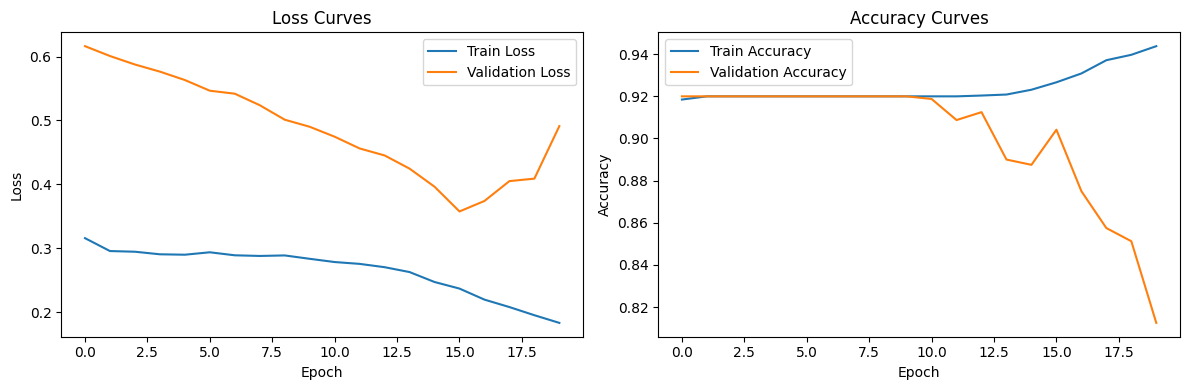

In [ ]:
import tensorflow as tf
import numpy as np

# --- Training Configuration ---
batch_size = 32  # You can experiment with different batch sizes (e.g., 16, 32, 64)
epochs = 20      # Start with a smaller number of epochs and increase if needed
input_shape = (64, 64, 1) # Ensure this is consistent

# --- Prepare Training Data (if you haven't run the data reshaping cell recently, run it again) ---
# (Assuming you have already run the cell that reshapes train_pairs, val_pairs and converts data types)
# If not, make sure to run the data preparation cell before this training cell


# --- Train the Siamese Network ---
print("Starting training...")
history = siamese_net.fit(
    [pairs_train_img1, pairs_train_img2], # Input pairs (two branches)
    train_labels,                        # Training labels
    batch_size=batch_size,
    epochs=epochs,
    validation_data=([pairs_val_img1, pairs_val_img2], val_labels) # Validation data for monitoring
)
print("Training finished!")


# --- Evaluate the Model after Training ---
print("\n--- Evaluate on Validation Set ---")
val_loss, val_accuracy = siamese_net.evaluate([pairs_val_img1, pairs_val_img2], val_labels)
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")


# --- Plot Training History (Loss and Accuracy) ---
import matplotlib.pyplot as plt

# Loss Curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy Curves
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
print("--- Sample of Train Labels ---")
print(train_labels[:20])  # Print the first 20 train labels
print("--- Label Distribution in Training Set ---")
unique_train_labels, counts_train_labels = np.unique(train_labels, return_counts=True)
print(dict(zip(unique_train_labels, counts_train_labels))) # Print counts of each label

print("\n--- Sample of Validation Labels ---")
print(val_labels[:20])    # Print the first 20 validation labels
print("--- Label Distribution in Validation Set ---")
unique_val_labels, counts_val_labels = np.unique(val_labels, return_counts=True)
print(dict(zip(unique_val_labels, counts_val_labels))) # Print counts of each label


--- Sample of Train Labels ---
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
--- Label Distribution in Training Set ---
{0: 840, 1: 9660}

--- Sample of Validation Labels ---
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
--- Label Distribution in Validation Set ---
{0: 192, 1: 2208}
